# Introduction

MovieLens is a website that employs a movie recommender system to suggest new films to its users based on their own personalized movie preferences. The idea is that users can rate several of their favorite (or least favorite) films, and a collaborative filtering algorithm is used to find the most popular movies enjoyed by users with similar tastes.

MovieLens has made available a small subset of its data compiled by the GroupLens Research Project at the University of Minnesota from September 19, 1997 to April 22, 1998. These data contain 100,000 movie ratings on a scale of 1 to 5 for 1,682 movies made by 943 users. Here, we will dig through some of this data to see what kinds of movies people have watched, which are most popular, and we will set up a simple movie recommender system based on a cosine similarity approach.

# Exploring the Data

Let's load in the data. There are three datasets - one containing demographic information for each of the users, one containing the movies, and one containing the ratings.

In [646]:
import seaborn as sns
import pandas as pd
import numpy as np

import matplotlib.pyplot as mp
%matplotlib inline

file1 = '/Users/degrave/DataScience/site/movies/user.txt'
file2 = '/Users/degrave/DataScience/site/movies/item.txt'
file3 = '/Users/degrave/DataScience/site/movies/data.txt'

u_cols = ['UserID','Age','Sex','Occupation','ZIPCode']
r_cols = ['UserID','MovieID','Rating','Timestamp']
m_cols = ['MovieID','MovieTitle','ReleaseDate','VideoReleaseDate',
          'IMDbURL','Unknown','Action','Adventure', 'Animation','Childrens',
          'Comedy','Crime','Documentary','Drama','Fantasy','FilmNoir','Horror',
          'Musical','Mystery','Romance','SciFi','Thriller','War','Western']

users   = pd.read_csv(file1, sep='|', names=u_cols)
movies  = pd.read_csv(file2, sep='|', names=m_cols)
ratings = pd.read_csv(file3, sep='\t', names=r_cols)

Let's first look at the user data.

In [647]:
users.head()

,UserID,Age,Sex,Occupation,ZIPCode
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213


The user data contains the age, sex, occupation, and ZIP Code for each of the 943 participants. There are a total of 670 males and 273 females in the sample. Let's take a look at the distribution of user ages.

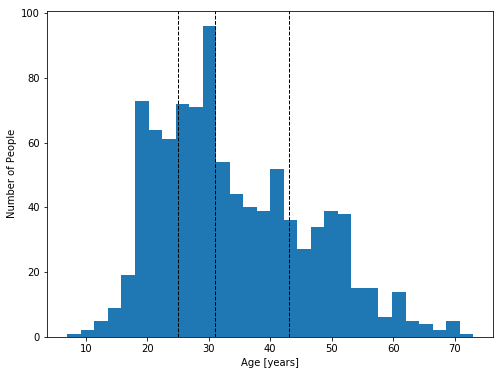

In [648]:
ax = users['Age'].plot.hist(bins=30, figsize=(8,6))
ax.set_xlabel('Age [years]')
ax.set_ylabel('Number of People')

ax = [mp.axvline(i, color='k', ls='--', lw=1) for i in
         users['Age'].quantile([0.25,0.50,0.75]).values]

The youngest participant in data was only seven years old, while the oldest was 73. Those users are pretty tech savvy considering their particular age brackets! The vertical black dashed lines denote the 1st and 3rd quartiles, along with the median value of the distribution. The majority of participants, were between 20 and 30 years old, though a significant portion of the population lays outside of this range.

We can also take a look at the occupations of these individuals.

Text(0,0.5,'Number of People')

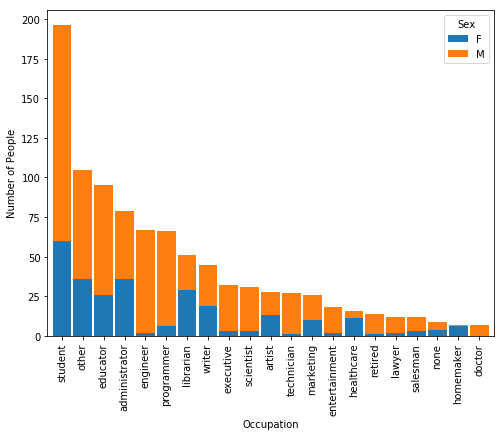

In [649]:
xtab = pd.crosstab(users['Occupation'], users['Sex'])

xtab['Total'] = xtab.sum(axis=1)

ax = xtab.sort_values('Total', ascending=False)[['F','M']].plot.bar(stacked=True, width=0.9, figsize=(8,6))
ax.set_xlabel('Occupation')
ax.set_ylabel('Number of People')

The most common occupation listed is *student*, comprising about 20% of all users. Of note is the unfortunate underrepresentation of females in certain fields like *engineer*, *programmer*, *executive*, and *scientist*.

The ZIP Codes for each user are also listed, though they aren't of much use if we can't visualize their location. Let's use the open-source website OpenHeatMap.com to quickly plot them up.

<img src="https://github.com/degravek/notebooks/blob/master/images/heatmap.png?raw=true" width="80%">

The map shows that user locations are concentrated heavily along the east and west coasts, though the zip-code with the most users is actually Minneapolis, Minnesota (ZIP Code 55414, with 9 individuals). A sizable fraction of users are also located in both the midwest and southeast regions of the country, while the west and southwest regions are pretty sparse. Though not shown here, there are also several users in both Alaska and Hawaii.

Let's now take a look at the movie dataframe.

In [650]:
movies.head()

,MovieID,MovieTitle,ReleaseDate,VideoReleaseDate,IMDbURL,Unknown,Action,Adventure,Animation,Childrens,...,Fantasy,FilmNoir,Horror,Musical,Mystery,Romance,SciFi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


The dataframe contains information regarding the title, release date, and genre of each movie in the dataset. Let's take a quick look at the different movie genres.

Text(0,0.5,'Number of Movies')

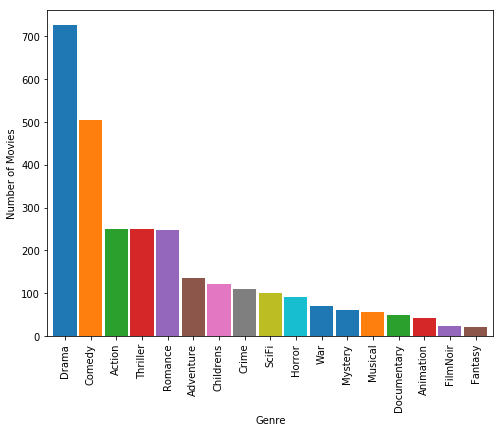

In [651]:
ax = movies.iloc[:,6:-1].sum(axis=0).sort_values(ascending=False).plot.bar(width=0.9, figsize=(8,6))
ax.set_xlabel('Genre')
ax.set_ylabel('Number of Movies')

The five most common genre tags for the various movies in order are drama, comedy, action, thriller, and romance. Several of the lesser-used tags seem to be more in the line of "sub-genres" like "crime", "fantasy", and "war".

Let's now examine the dataframe containing the movie ratings.

In [600]:
ratings.head()

,UserID,MovieID,Rating,Timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


The dataframe contains information regarding the rataing for each movie, a numerical value specifying the movie ID, and the ID of each user doing the rating.

Let's check out the ten most-rated movies in our list. To do this, we can use the Pandas *merge* command to join the ratings dataframe to the movie dataframe on the *MovieID* column. This will combine the two dataframes so that the correct movie titles are lined up with the correct movie ID numbers, ratings, etc.

In [652]:
df = ratings.merge(movies, on='MovieID').merge(users, on='UserID')

We can now sort the new dataframe by the number of times each movie title appears.

Text(0,0.5,'')

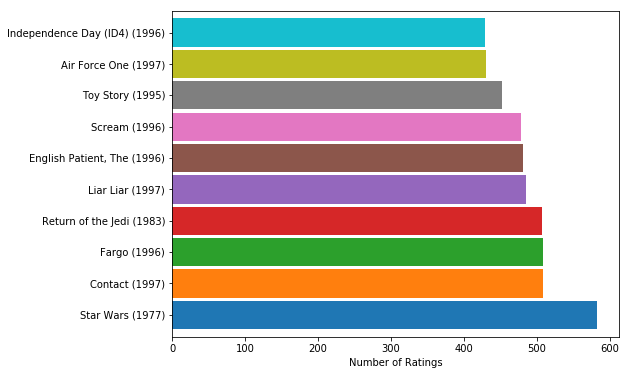

In [653]:
df['MovieTitle'].value_counts()[:10].plot.barh(width=0.9, figsize=(8,6))
mp.xlabel('Number of Ratings')
mp.ylabel('')

No surprise that a movie like Star Wars would top the list! Contact, Scream, and Independence Day are some of my favorite movies as well. I'm a little surprised that Fargo and The English Patient made the list, though. I've never heard people talk about them much, but I might have to check them out!

Let's now look at the ten most highly rated movies. There are a couple of ways we can do this. The first way is to simply sort all films by their average rating and take the first ten that are listed. However, there is a potential problem with this method - several films have been given a perfect score of 5, but have been rated only once or twice. Surely a film with a slightly lower rating but having several hundred votes is more trustworthy than one with a single vote. We therefore need a way to weight the ratings by the number of votes the film has received. To overcome this problem, we can use a Bayesian weighted estimate similar to what IMDb uses for its top 250 list. The Bayesian estimate, $BE$, is given as

$$BE = \frac{v}{v+m}R + \frac{m}{v+m}C,$$

where

* $R$ = The mean rating from everyone who has seen a particular movie.
* $v$ = The number of times a particular movie has been rated.
* $m$ = The minimum number of votes required to be in the top ten.
* $C$ = The mean rating of all films in the entire movie list.

We'll use a value of m = 100 so that a movie must have at least 100 votes to make the list. Let's see what we get!

In [663]:
def BayesianRating(inp, v):
    top_movies = pd.DataFrame()
    top_movies['MeanRating'] = inp.groupby('MovieTitle')['Rating'].mean()
    top_movies['NumRatings'] = inp.groupby('MovieTitle')['Rating'].count()

    fullrating = df['Rating'].mean()

    top_movies['Score'] = top_movies['MeanRating']*top_movies['NumRatings']/ \
                          (top_movies['NumRatings'] + v) + \
                          fullrating*v/(top_movies['NumRatings'] + v)

    top_movies.sort_values('Score', ascending=False, inplace=True)
    return top_movies

In [664]:
top_movies = BayesianRating(df, 100)

Let's check out this new dataframe.

In [665]:
top_movies.head(10)

,MeanRating,NumRatings,Score
MovieTitle,,,
Star Wars (1977),4.358491,583,4.237168
Schindler's List (1993),4.466443,298,4.231121
"Shawshank Redemption, The (1994)",4.445230,283,4.206230
Casablanca (1942),4.456790,243,4.186548
"Usual Suspects, The (1995)",4.385768,267,4.152550
"Godfather, The (1972)",4.283293,413,4.136425
"Silence of the Lambs, The (1991)",4.289744,390,4.134665
Raiders of the Lost Ark (1981),4.252381,420,4.113435
Rear Window (1954),4.387560,209,4.109987


We can now sort this listing by the newly-computed Bayesian estimate score and plot the results.

Text(0,0.5,'')

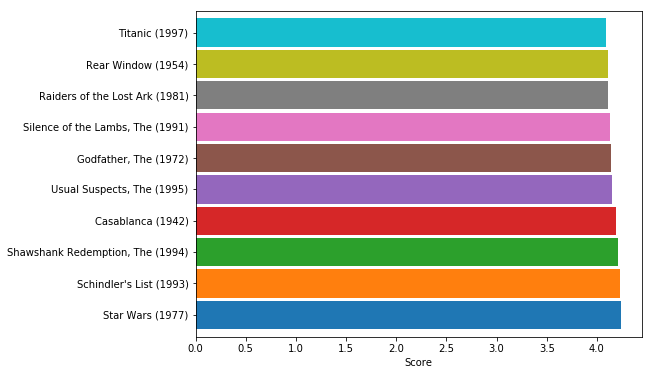

In [667]:
ax = top_movies['Score'][:10].plot.barh(width=0.9, figsize=(8,6))
ax.set_xlabel('Score')
ax.set_ylabel('')

As expected, some very popular movies make the list! The one I'm surprised about, though, is the film "Rear Window". A quick Google search shows that this film has a rating of 8.5/10 on IMDb and a 100% on Rotten Tomatoes, so the fact that this movie shows up here does make sense. One will note that Raiders of the Lost Ark shows up with a higher score than Rear Window, even though Rear Window's mean rating across all users is higher. This is due to the fact that it is rated much less frequently than Raiders of the Lost Ark. Our Bayesian estimate seems to work!

We can merge the new, large dataframe with the user dataframe on the UserID column. This will allow us to see separately what males and females are watching. We group the dataframe by sex, and computed the weighted rating for movies with more than 50 reviews.

Let's look at the most highly rated movies.

In [671]:
movies_F = tmp.groupby('Sex').get_group('F')
movies_F_top = BayesianRating(movies_F, 50)

movies_M = tmp.groupby('Sex').get_group('M')
movies_M_top = BayesianRating(movies_M, 50)

(0, 5)

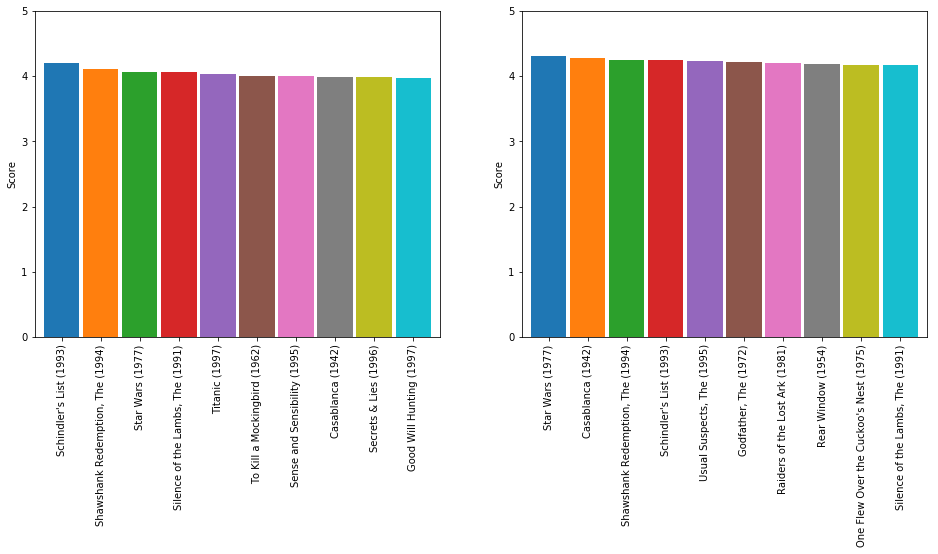

In [672]:
fig, axes = mp.subplots(nrows=1, ncols=2, figsize=(16,6))

ax = movies_F_top['Score'][:10].plot.bar(width=0.9, ax=axes[0])
ax.set_ylabel('Score')
ax.set_xlabel('')
ax.set_ylim(0,5)

ax = movies_M_top['Score'][:10].plot.bar(width=0.9, ax=axes[1])
ax.set_ylabel('Score')
ax.set_xlabel('')
ax.set_ylim(0,5)

I'm a little surprised that there are many similarities between the two lists! Notably, movies like Star Wars, Shawshank Redemption, and Schindler's list seem to be universally liked between the sexes.

Lastly, let's take a quick look at movies by release date. The release dates are strings in the format 01-Jan-1995. We can split these strings on the dashes and isolate the year.

Text(0,0.5,'Number of Movies')

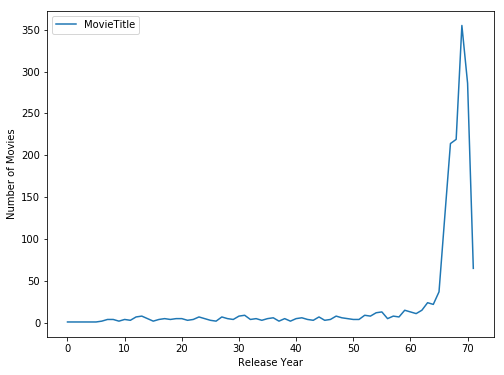

In [674]:
movies['Year'] = movies['ReleaseDate'].apply(lambda x: x.split('-')[-1] if type(x) == str else 0)

ax = movies.groupby('Year')['MovieTitle'].count().reset_index().plot(figsize=(8,6))
ax.set_xlabel('Release Year')
ax.set_ylabel('Number of Movies')

The movies span many decades. The earliest film was released in 1922, while the most recent was released in 1998. There are more than 10 times more movies produced in the 1990's than at any other decade represented in the dataset. It is not clear if this is simply due to the fact that more films were produced during that time, or if there is simply an underrepresentation of very old films in this dataset. Probably a combination of both.

# A Simple Movie Recommender System

Okay, let's set up the movie recommender system! The system we will set up uses a technique called collaborative filtering. A collaborative filtering algorithm makes movie recommendations to a new user based on what films other similar individuals have liked in the past. There are several ways we can identify those users with similar tastes. Perhaps the simplest way is to employ a kind of k-nearest neighbors approach. With this method, we could compute a Euclidean distance between the rating values given by a new user and all other users in the dataset who have watched the same movies. For example, let's suppose a new user has seen the movies Toy Story, Independence Day, and Contact, and has rated them 4, 3, and 2 stars out of 5 respectively. Let's also suppose another user has seen those same movies, and has rated them 5, 2, and 4 stars out of 5 respectively. The Euclidean distance between the two users is then computed as

$$d = \sqrt{(4-5)^2 + (3-2)^2 + (2-4)^2} = 2.45.$$

The smaller the distance value, the greater the similarity.

We can see in the example above that the smallest value this similarity index can take is zero. A value of zero means that the ratings given by the two users are identical. We can also define a second useful index called the cosine similarity. Cosine similarity lends its name to computing the cosine of the angle between two vectors. Mathematically, this is written as

$$\mathrm{cosine\,\,similarity} = \cos(\theta) = \frac{\sum_i^n A_i\,B_i}{\sqrt{\sum_i^n A_i^2} \sqrt{\sum_i^n B_i^2}},$$

where $\theta$ is the angle between vectors $A$ and $B$, and the subscript represents their $i^\mathrm{th}$ element. For our purposes, $A$ is the vector of movie ratings given by some new user (the user we're trying to recommend movies to), and $B$ represents the individual vectors of movie ratings given by each user in the MovieLens dataset.

In this scheme, two users that have liked and disliked exactly the same movies are given a cosine similarity value of 1 (i.e., there is no angle between their vectors), while two perfectly dissimilar users (where one user has liked all movies that the other disliked, and vice versa) are given a value of -1 (i.e., the angle between their vectors is 180 degrees).

Let's get started by first defining a function to calculate the Euclidean and cosine similarities between users. The function, called *similarity*, takes in a movie rating vector from some new user and computes the similarity between it and every user in the MovieLens dataset. This is done only if the two individuals have ten movies in common between them. It then returns the similarity values as a dataframe.

In [685]:
from sklearn.metrics import pairwise_distances

def similarity(inp, movie_matrix, scorer):

    n, m = [], []
    for i in movie_matrix.columns:
        if i != inp:
            sub_movie_matrix = movie_matrix[[inp, i]].dropna()

            if len(sub_movie_matrix) >= 10:
                a = sub_movie_matrix[i].values.reshape(1,-1)
                b = sub_movie_matrix[inp].values.reshape(1,-1)

                if scorer == 'cosine':
                    score = cosine_similarity(a, b)[0][0]
                elif scorer == 'euclidean':
                    score = np.sqrt(np.sum((a-b)**2))
                n.append(i)
                m.append(score)
    return pd.DataFrame({'UserID': n, 'Similarity': m})

Next, we define a new dataframe called "moviemat" in which the index is composed of all movie titles, the column names are the user ID's of all reviewers, and the column values are the ratings.

Ratings take on integer values of between 1 and 5. To take into account both the similarity *and* dissimilarity of users, we subtract off the mean (3.0) from each rating so that they take on values between -2 and +2. This ensures that ratings of 1 or 2 are given by users that have "disliked" a movie to varying degrees (after subtraction, these now take on values of -2 and -1 respectively), while ratings of 4 or 5 are given by users that have "liked" a movie to varying degrees (after subtraction, these now take on values of 1 and 2 respectively). Under this definition, users that have given a movie a rating of 3 stars have neither liked nor disliked the film.

In [686]:
movie_matrix = pd.pivot_table(data=df, index='MovieTitle', columns='UserID', values='Rating')

movie_matrix = movie_matrix - 3.0

Let's take a look at the moviemat dataframe.

In [687]:
movie_matrix.head()

UserID,1,2,3,4,5,6,7,8,9,10,...,934,935,936,937,938,939,940,941,942,943
MovieTitle,,,,,,,,,,,,,,,,,,,,,
'Til There Was You (1997),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1-900 (1994),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
101 Dalmatians (1996),-1.0,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,...,-1.0,NaN,NaN,-1.0,1.0,NaN,NaN,NaN,NaN,NaN
12 Angry Men (1957),2.0,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
187 (1997),NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The dataframe contains many missing values, but this is okay. This simply means that a user has not rated these particular films. Let's now use our new function to compute the similarity metrics between a new user and all others. For simplicity, the new user is chosen to be the very first one in the MovieLens dataset (the one with *UserID* = 1). We then sort these values and grab the 25 individuals most similar to user 1.

Let's take a look at the five most similar individuals.

In [720]:
r_cos = similarity(1, movie_matrix, 'cosine')
r_cos.sort_values('Similarity', ascending=False, inplace=True)

r_euc = similarity(1, movie_matrix, 'euclidean')
r_euc.sort_values('Similarity', ascending=True, inplace=True)

print('cosine:', r_cos['UserID'].tolist()[:5])
print('euclid:', r_euc['UserID'].tolist()[:5])

cosine: [433, 516, 691, 165, 874]
euclid: [516, 359, 433, 800, 691]


The two metrics return a similar list of users with tastes like *UserID* 1. We can also look at the five least similar individuals.

In [721]:
print('cosine:', r_cos['UserID'].tolist()[-5:])
print('euclid:', r_euc['UserID'].tolist()[-5:])

cosine: [405, 617, 471, 161, 445]
euclid: [655, 537, 181, 269, 405]


We see that the user whose tastes are closest to *UserID* 1 is *UserID* 433 or 516 depending on which distance metric is used. The person least similar to *UserID* 1 is *UserID* 445 or 405.

We now make a new dataframe which compiles all movies seen by the similar individuals. The dataframe contains the *UserID*, *MovieTitle*, and *Rating* given by each person.

In [722]:
movies_seen = df[df['UserID'].isin(r_cos['UserID'][:25].tolist())][['UserID','MovieTitle','Rating']]

For each movie in the compiled list, we can compute a weighted Bayesian estimate just as we did earlier in the exploratory analysis.

In [723]:
BayesianRating(movies_seen, 100).head(10)

,MeanRating,NumRatings,Score
MovieTitle,,,
Star Wars (1977),4.687500,16,3.689534
Fargo (1996),4.733333,15,3.686835
"Godfather, The (1972)",4.666667,12,3.651661
Pulp Fiction (1994),4.727273,11,3.648523
Raiders of the Lost Ark (1981),4.700000,10,3.636236
"Empire Strikes Back, The (1980)",4.777778,9,3.632899
Schindler's List (1993),4.875000,8,3.629500
Return of the Jedi (1983),4.266667,15,3.625965
Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1963),4.750000,8,3.620241


Finally, here are ten movies that we can recommend to the new user based on our collaborative filtering algorithm. These are films that I myself happen to like very much! However, they're also all very highly rated. Maybe our algorithm is simply recommending highly rated films to every new user we give it. To test this, we can look at the individual with *UserID* 445. This user has the lowest similarity index relative to *UserID* 1, and so we should expect that the films our algorithm suggests to them to be quite different than the ones given in the list above. The list below shows the films recommended to *UserID* 445.

In [711]:
r_cos = similarity(445, movie_matrix, 'cosine')
r_cos.sort_values('Similarity', ascending=False, inplace=True)

r_euc = similarity(445, movie_matrix, 'euclidean')
r_euc.sort_values('Similarity', ascending=True, inplace=True)

print('cosine:', r_cos['UserID'].tolist()[:5])
print('euclid:', r_euc['UserID'].tolist()[:5])

cosine: [639, 3, 900, 181, 828]
euclid: [639, 900, 573, 726, 129]


In [714]:
movies_seen = df[df['UserID'].isin(r_cos['UserID'][:25].tolist())][['UserID','MovieTitle','Rating']]

In [718]:
BayesianRating(movies_seen, 100).head(10)

,MeanRating,NumRatings,Score
MovieTitle,,,
Boogie Nights (1997),4.100000,10,3.581691
"Silence of the Lambs, The (1991)",4.285714,7,3.579308
Pulp Fiction (1994),4.333333,6,3.575340
12 Angry Men (1957),4.400000,5,3.571295
"Full Monty, The (1997)",3.900000,10,3.563509
Shine (1996),4.666667,3,3.562971
As Good As It Gets (1997),4.666667,3,3.562971
Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1963),4.666667,3,3.562971
Conan the Barbarian (1981),5.000000,2,3.558686


Well, the good news is that the list is not simply composed of very highly rated films that essentially everyone likes. There are a few well-liked films included like Silence of the Lambs and Casablanca, but there are also, as we might hope to see, several more obscure films included in there like Boogie Nights, 12 Angry Men, and The Full Monty.

Well, that's all I have for now. Thanks for following along!

<script>
  $(document).ready(function(){
    $('div.prompt').hide();
    $('div.back-to-top').hide();
    $('.breadcrumb').hide();
    $('.hidden-print').hide();
  });
</script>